## Oregon State COVID Response Analysis
This notebook contains the work to identify associations between the Oregon state governmental response and the COVID-19 case count throughout the pandemic.


## Data Cleanup
As with most data mining projects, we will need to clean up the given data file in order to focus on the goal at hand. The "all-states-history.csv" file is a dataset of U.S. COVID-19 cases and deaths dating from the start of the pandemic to 11/29/20 and was sourced from [The Covid Tracking Project](https://covidtracking.com/data). We are analyzing 3 periods throughout this timeline:

- Early Breakout (Early March -> May)
- Summer (June -> August)
- Fall/Present (September -> Late November)

We will divide up the data into 3 different frames according to these periods.

In order to analyze with state policy actions, we will merge data from the [Oxford Covid-19 Government Response Tracker](https://github.com/OxCGRT/covid-policy-tracker) github dataset titled 'state-policies.csv'. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import squarify
import seaborn as sns

# for market basket analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

Need to a way to discretize and format data too be suitable for apriori analysis. The function below will discretize the necessary columns into bins and set the values to strings according to the bin they are placed in.  

In [2]:
def discretize_data2(arr, k):
    cols = arr.columns
    for i in cols:
        bin_range = pd.cut(arr[i],k)
        col_copy = arr[i].astype('str')
        for j in range(len(col_copy)):
            col_copy[j] = i + "" +str(bin_range[j])
            
        arr[i] = col_copy   

Initializing the dataframes

In [10]:
# COVID tracking project data
covid_data = pd.read_csv('all-states-history.csv')

# state plicy data
policy_data = pd.read_csv('state-policies.csv')

Cleaning up Covid data to only include California instances and the appropriate attributes

In [11]:
#isolating the columns we need
columns_to_show = ['date','state','death','deathConfirmed','deathIncrease','hospitalized','hospitalizedIncrease','negative'
                   ,'negativeIncrease','positive','positiveIncrease','totalTestResults','totalTestResultsIncrease']

#isolating only for OR data and putting in order March->November
covid_clean_data = covid_data[covid_data['state'] == 'OR']
covid_clean_data = covid_clean_data[columns_to_show]
covid_clean_data = covid_clean_data.iloc[::-1]

#reindexing for weekly processing 
covid_clean_data['date'] = covid_clean_data['date'].astype('datetime64[ns]')
covid_clean_data = covid_clean_data.set_index('date')

# isolating the columns that need to be summed when converting to weekly index
increase_cols = covid_clean_data[['deathIncrease','hospitalizedIncrease','negativeIncrease','positiveIncrease','totalTestResultsIncrease']]
#weekly_data = columns_to_sum.resample('W', label='right', closed='right').sum()
increase_cols = increase_cols.reset_index(drop = True)

# converting remaining non-sum columns to weekly index
remaining_cols = covid_clean_data[['state','death','deathConfirmed','hospitalized', 'negative','positive','totalTestResults']]
#remaining_cols = remaining_cols.resample('W').backfill().reset_index()
#remaining_cols.head(39)

#merging and resetting the datframe order to be more clear
#covid_clean_data = pd.merge(remaining_cols, weekly_data, left_index = True, right_index = True).fillna(0)
#covid_clean_data = covid_clean_data[['date','state','death','deathIncrease','deathConfirmed','hospitalized', 'hospitalizedIncrease','negative',
                        #'negativeIncrease','positive', 'positiveIncrease','totalTestResults','totalTestResultsIncrease']]
discretize_data2(increase_cols,4)
increase_cols.head()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,"deathIncrease(-0.021, 5.25]","hospitalizedIncrease(-14.164, 27.0]","negativeIncrease(-65.012, 2950.0]","positiveIncrease(-1.674, 418.5]","totalTestResultsIncrease(-12.408, 3102.0]"
1,"deathIncrease(-0.021, 5.25]","hospitalizedIncrease(-14.164, 27.0]","negativeIncrease(-65.012, 2950.0]","positiveIncrease(-1.674, 418.5]","totalTestResultsIncrease(-12.408, 3102.0]"
2,"deathIncrease(-0.021, 5.25]","hospitalizedIncrease(-14.164, 27.0]","negativeIncrease(-65.012, 2950.0]","positiveIncrease(-1.674, 418.5]","totalTestResultsIncrease(-12.408, 3102.0]"
3,"deathIncrease(-0.021, 5.25]","hospitalizedIncrease(-14.164, 27.0]","negativeIncrease(-65.012, 2950.0]","positiveIncrease(-1.674, 418.5]","totalTestResultsIncrease(-12.408, 3102.0]"
4,"deathIncrease(-0.021, 5.25]","hospitalizedIncrease(-14.164, 27.0]","negativeIncrease(-65.012, 2950.0]","positiveIncrease(-1.674, 418.5]","totalTestResultsIncrease(-12.408, 3102.0]"


Cleaning up state policy dataframe:

In [12]:
#isolating data only about the current state of interest, Oregon
policy_clean_data = policy_data[policy_data['RegionName'] == 'Oregon']
#deleting rows whose dates are outside of the scope of this project
policy_clean_data = policy_clean_data.iloc[60:] #delete the first 60 rows due to their January - February dates
policy_clean_data = policy_clean_data.iloc[:-3,] #as well as the last 3 rows due to their December dates

#declaring and extracting columns of interest from the original dataset
columns_of_interest = ['Date', 'C1_School closing', 'C2_Workplace closing', 
                       'C3_Cancel public events', 'C4_Restrictions on gatherings', 'C6_Stay at home requirements', 
                       'C7_Restrictions on internal movement', 'C8_International travel controls', 
                       'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', 
                       'H4_Emergency investment in healthcare', 
                       'H6_Facial Coverings']
policy_clean_data = policy_clean_data[columns_of_interest].fillna(0)

# reformating date section and range of dates needed
policy_clean_data = policy_clean_data.reset_index(drop = True)
from datetime import datetime as dt

date_col = policy_clean_data['Date'].astype('str')
for i in range(policy_clean_data.shape[0]):
    date_col[i] = dt.strptime(date_col[i], "%Y%m%d")
    
policy_clean_data['Date'] = date_col

start_date = dt.strptime('20200306', "%Y%m%d")
end_date = dt.strptime('20201129', "%Y%m%d")

policy_clean_data = policy_clean_data.rename(columns = {"Date": "date"})

policy_clean_data = policy_clean_data.set_index('date')

policy_clean_data = policy_clean_data[start_date:end_date].reset_index(drop=True)
policy_clean_data.head()

,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H6_Facial Coverings
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


Changing values of policy_clean_data to the type of policy each number corresponds to:

In [13]:
#C1_School closing
policy_clean_data['C1_School closing'] = policy_clean_data['C1_School closing'].replace(0, 'no measures, school closing')
policy_clean_data['C1_School closing'] = policy_clean_data['C1_School closing'].replace(1, 'recommend closing or all schools open with alterations resulting in significant differences compared to non-Covid-19 operations')
policy_clean_data['C1_School closing'] = policy_clean_data['C1_School closing'].replace(2, 'require closing (only some levels or categories, eg just high school, or just public schools)')
policy_clean_data['C1_School closing'] = policy_clean_data['C1_School closing'].replace(3, 'require closing all levels, school closing')
#C2_Workplace closing
policy_clean_data['C2_Workplace closing'] = policy_clean_data['C2_Workplace closing'].replace(0, 'no measures, workplace closing')
policy_clean_data['C2_Workplace closing'] = policy_clean_data['C2_Workplace closing'].replace(1, 'recommend closing (or recommend work from home)')
policy_clean_data['C2_Workplace closing'] = policy_clean_data['C2_Workplace closing'].replace(2, 'require closing (or work from home) for some sectors or categories of workers')
policy_clean_data['C2_Workplace closing'] = policy_clean_data['C2_Workplace closing'].replace(3, 'require closing (or work from home) for all-but-essential workplaces (eg grocery stores, doctors)')
#C3_Cancel public events
policy_clean_data['C3_Cancel public events'] = policy_clean_data['C3_Cancel public events'].replace(0, 'no measures, cancel public events')
policy_clean_data['C3_Cancel public events'] = policy_clean_data['C3_Cancel public events'].replace(1, 'recommend cancelling public events')
policy_clean_data['C3_Cancel public events'] = policy_clean_data['C3_Cancel public events'].replace(2, 'require cancelling public events')
#C4_Restrictions on gatherings                                                                                            
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(0, 'no restrictions on gatherings')                                                                                              
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(1, 'restrictions on very large gatherings (the limit is above 1000 people)')                                                                                              
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(2, 'restrictions on gatherings between 101-1000 people')                                                                                              
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(3, 'restrictions on gatherings between 11-100 people')                                                                                              
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(4, 'restrictions on gatherings of 10 people or less')
#C6_Stay at home requirements                                                                                            
policy_clean_data['C6_Stay at home requirements'] = policy_clean_data['C6_Stay at home requirements'].replace(0, 'no measures for stay at home requirement')
policy_clean_data['C6_Stay at home requirements'] = policy_clean_data['C6_Stay at home requirements'].replace(1, 'recommend not leaving house')
policy_clean_data['C6_Stay at home requirements'] = policy_clean_data['C6_Stay at home requirements'].replace(2, 'require not leaving house with exceptions for daily exercise, grocery shopping, and "essential" trips')
policy_clean_data['C6_Stay at home requirements'] = policy_clean_data['C6_Stay at home requirements'].replace(3, 'require not leaving house with minimal exceptions (eg allowed to leave once a week, or only one person can leave at a time, etc)')
#C7_Restrictions on internal movement
policy_clean_data['C7_Restrictions on internal movement'] = policy_clean_data['C7_Restrictions on internal movement'].replace(0, 'no measures on restrictions on internal movement')
policy_clean_data['C7_Restrictions on internal movement'] = policy_clean_data['C7_Restrictions on internal movement'].replace(1, 'recommend not to travel between regions/cities')
policy_clean_data['C7_Restrictions on internal movement'] = policy_clean_data['C7_Restrictions on internal movement'].replace(2, 'internal movement restrictions in place')
#C8_International travel controls
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(0, 'no restrictions on international travel')
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(1, 'screening arrivals on international travel')
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(2, 'quarantine arrivals from some or all regions for international travel')
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(3, 'ban arrivals from some regions for international travel')
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(4, 'ban on all regions or total border closure')
#H1_Public information campaigns
policy_clean_data['H1_Public information campaigns'] = policy_clean_data['H1_Public information campaigns'].replace(0, 'no Covid-19 public information campaign')
policy_clean_data['H1_Public information campaigns'] = policy_clean_data['H1_Public information campaigns'].replace(1, 'public officials urging caution about Covid-19')
policy_clean_data['H1_Public information campaigns'] = policy_clean_data['H1_Public information campaigns'].replace(2, 'coordinated public information campaign (eg across traditional and social media)')
#H2_Testing policy
policy_clean_data['H2_Testing policy'] = policy_clean_data['H2_Testing policy'].replace(0, 'no testing policy')
policy_clean_data['H2_Testing policy'] = policy_clean_data['H2_Testing policy'].replace(1, 'only those who both (a) have symptoms AND (b) meet specific criteria (eg key workers, admitted to hospital, came into contact with a known case, returned from overseas)')
policy_clean_data['H2_Testing policy'] = policy_clean_data['H2_Testing policy'].replace(2, 'testing of anyone showing Covid-19 symptoms')
policy_clean_data['H2_Testing policy'] = policy_clean_data['H2_Testing policy'].replace(3, 'open public testing (eg "drive through" testing available to asymptomatic people)')
#H3_Contact tracing
policy_clean_data['H3_Contact tracing'] = policy_clean_data['H3_Contact tracing'].replace(0, 'no contact tracing')
policy_clean_data['H3_Contact tracing'] = policy_clean_data['H3_Contact tracing'].replace(1, 'limited contact tracing; not done for all cases')
policy_clean_data['H3_Contact tracing'] = policy_clean_data['H3_Contact tracing'].replace(2, 'comprehensive contact tracing; done for all identified cases')
#H4_Emergency investment in healthcare
### not a code, simply records the monetary value in USD
policy_clean_data['H4_Emergency investment in healthcare'] = policy_clean_data['H4_Emergency investment in healthcare'].mask(policy_clean_data['H4_Emergency investment in healthcare'] > 0, 'investment')
policy_clean_data['H4_Emergency investment in healthcare'] = policy_clean_data['H4_Emergency investment in healthcare'].replace(0, 'no new spending that day')

#H6_Facial Coverings
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(0, 'no policy on facial coverings')
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(1, 'recommended facial coverings')
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(2, 'facial coverings required in some specified shared/public spaces outside the home with other people present, or some situations when social distancing not possible')
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(3, 'facial coverings required in all shared/public spaces outside the home with other people present or all situations when social distancing not possible')
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(4, 'facial coverings required outside the home at all times regardless of location or presence of other people')
                                                                                              

In [14]:
policy_clean_data.head()

,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H6_Facial Coverings
0,"no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,no restrictions on international travel,public officials urging caution about Covid-19,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings
1,"no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,no restrictions on international travel,public officials urging caution about Covid-19,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings
2,"no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,no restrictions on international travel,public officials urging caution about Covid-19,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings
3,"no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,no restrictions on international travel,public officials urging caution about Covid-19,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings
4,"no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,no restrictions on international travel,public officials urging caution about Covid-19,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings


Merging dataframes to create the basket:

In [15]:
OR_basket = pd.merge(increase_cols, policy_clean_data, left_index=True, right_index=True)

## Analysis

Important OR Stats:

- Population (census.gov estimate): 4,217,737
- Land Area (estimate): 98,466 sq. mi.
- Population Density (statista.com): 43.9 people/sq. mi.

Before we jump into Apriori, it would be nice to get a vizual of the basket data, we will create a tree map similar to the one in Project 2's "apriori analysis" notebook: 

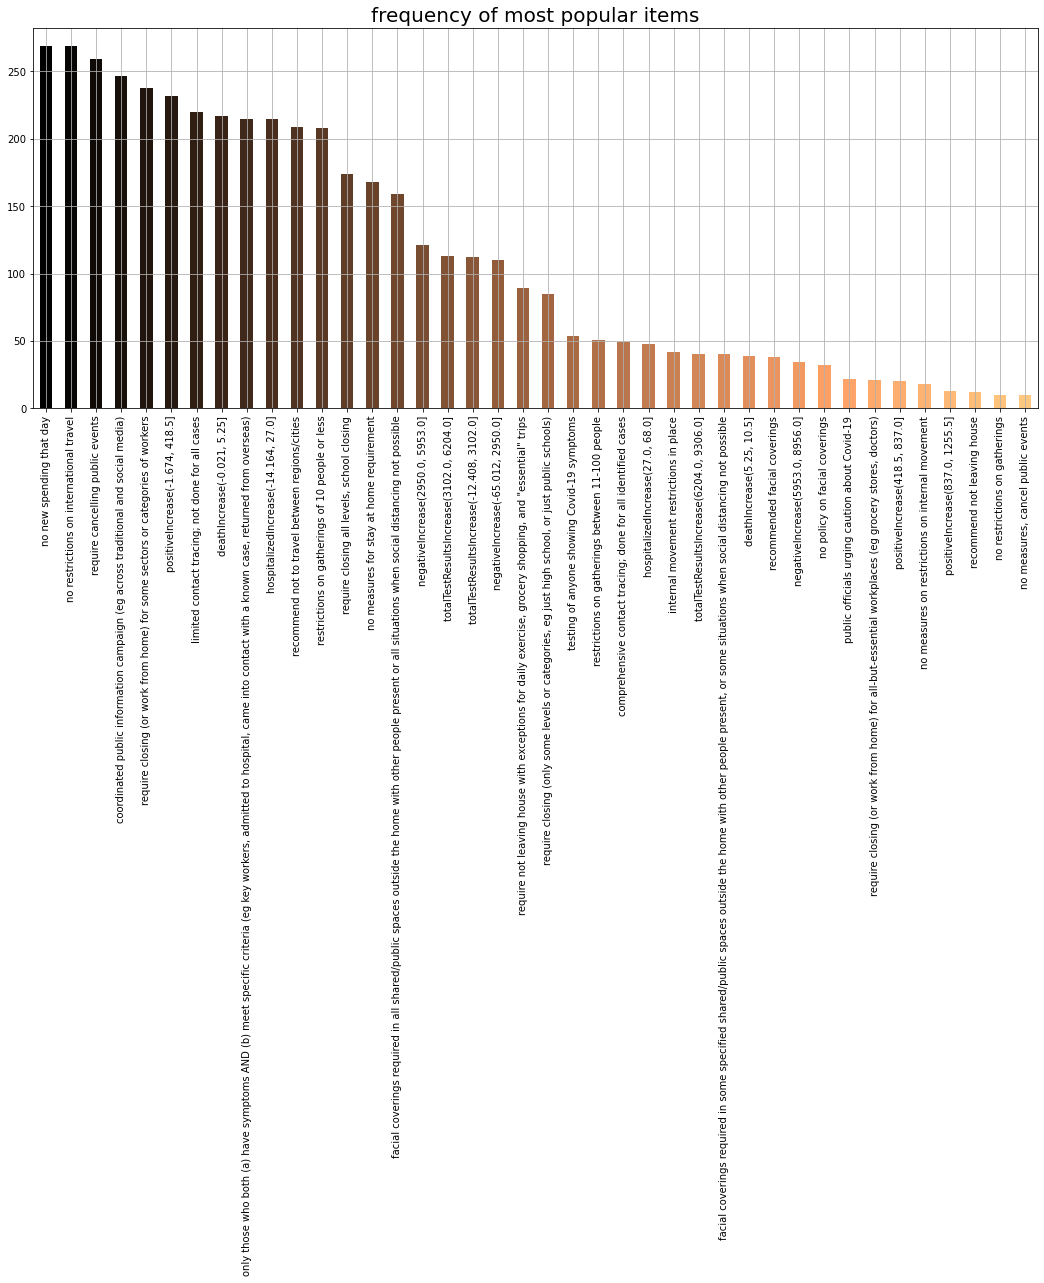

In [16]:
from wordcloud import WordCloud

all_elements = OR_basket.values.tolist()
flat_list = [item for sublist in all_elements for item in sublist]
temp_df = pd.DataFrame({'col':flat_list})


plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 40))
temp_df['col'].value_counts().head(40).plot.bar(color = color)
plt.title('frequency of most popular items', fontsize = 20)
plt.xticks(rotation = 90)
plt.grid()
plt.show()

As we can see, the most frequent items are:

- no new spending that day
- no restrictions on international travel
- require cancelling public events

This doesn't provide too much information for how mandates relate to trends in cases, so lets do some association mining.

Now that we have the data set up as a series of 'transactions' with items (basket), we just need to encode the items and then use Apriori analysis and find association rules:

In [18]:
basket_array = OR_basket.values
basket_cols = OR_basket.columns
te = TransactionEncoder()
te_dataset = te.fit(basket_array).transform(basket_array)

OR_te_basket = pd.DataFrame(te_dataset, columns = te.columns_)

In [19]:
OR_freq_itemsets = apriori(OR_te_basket, min_support=0.7, use_colnames=True)

In [20]:
OR_freq_itemsets['length'] = OR_freq_itemsets['itemsets'].apply(lambda x: len(x))

In [21]:
rules = association_rules(OR_freq_itemsets, metric="confidence", min_threshold=0.7)
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))

Now we can mine for associations:

In [22]:
len4 = rules[rules['antecedent_len'] >= 6]

len4.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len


In [23]:
contact_tracing = rules[(rules['antecedents'] == {'limited contact tracing; not done for all cases'})
                    & (rules['antecedent support'] >= 0.9) 
                    & (rules['confidence'] >= 0.9)]
len(contact_tracing)

0

In [24]:
school_restrictions = rules[(rules['antecedents'] == {'require closing all levels, school closing'})
                    & (rules['antecedent support'] >= 0.9) 
                    & (rules['confidence'] >= 0.9)]

school_restrictions.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len


In [25]:
work_restrictions = rules[(rules['antecedents'] == {'recommend closing (or recommend work from home)'})
                    & (rules['antecedent support'] >= 0.7) 
                    & (rules['confidence'] >= 0.7)]
work_restrictions.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len


In [26]:
public_events = rules[(rules['antecedents'] == {'require cancelling public events'})
                    & (rules['antecedent support'] >= 0.7) 
                    & (rules['confidence'] >= 0.7)]
public_events.head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
17,(require cancelling public events),(coordinated public information campaign (eg a...,0.962825,0.918216,0.918216,0.953668,1.038610,0.034134,1.765180,1
29,(require cancelling public events),"(deathIncrease(-0.021, 5.25])",0.962825,0.806691,0.769517,0.799228,0.990748,-0.007186,0.962825,1
38,(require cancelling public events),"(hospitalizedIncrease(-14.164, 27.0])",0.962825,0.799257,0.762082,0.791506,0.990303,-0.007463,0.962825,1
51,(require cancelling public events),(limited contact tracing; not done for all cases),0.962825,0.817844,0.780669,0.810811,0.991400,-0.006772,0.962825,1
63,(require cancelling public events),(no new spending that day),0.962825,1.000000,0.962825,1.000000,1.000000,0.000000,inf,1
75,(require cancelling public events),(no restrictions on international travel),0.962825,1.000000,0.962825,1.000000,1.000000,0.000000,inf,1
83,(require cancelling public events),(only those who both (a) have symptoms AND (b)...,0.962825,0.799257,0.762082,0.791506,0.990303,-0.007463,0.962825,1
85,(require cancelling public events),"(positiveIncrease(-1.674, 418.5])",0.962825,0.862454,0.825279,0.857143,0.993842,-0.005113,0.962825,1
88,(require cancelling public events),(recommend not to travel between regions/cities),0.962825,0.776952,0.776952,0.806950,1.038610,0.028883,1.155390,1
91,(require cancelling public events),(require closing (or work from home) for some ...,0.962825,0.884758,0.884758,0.918919,1.038610,0.032891,1.421314,1


In [27]:
gathering_restrictions = rules[(rules['antecedents'] == {'restrictions on gatherings of 10 people or less'})
                    & (rules['antecedent support'] >= 0.7) 
                    & (rules['confidence'] >= 0.7)]
gathering_restrictions.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
21,(restrictions on gatherings of 10 people or less),(coordinated public information campaign (eg a...,0.773234,0.918216,0.769517,0.995192,1.083833,0.059521,17.011152,1
67,(restrictions on gatherings of 10 people or less),(no new spending that day),0.773234,1.000000,0.773234,1.000000,1.000000,0.000000,inf,1
79,(restrictions on gatherings of 10 people or less),(no restrictions on international travel),0.773234,1.000000,0.773234,1.000000,1.000000,0.000000,inf,1
92,(restrictions on gatherings of 10 people or less),(require cancelling public events),0.773234,0.962825,0.773234,1.000000,1.038610,0.028745,inf,1
195,(restrictions on gatherings of 10 people or less),(coordinated public information campaign (eg a...,0.773234,0.918216,0.769517,0.995192,1.083833,0.059521,17.011152,1
230,(restrictions on gatherings of 10 people or less),(coordinated public information campaign (eg a...,0.773234,0.918216,0.769517,0.995192,1.083833,0.059521,17.011152,1
272,(restrictions on gatherings of 10 people or less),(coordinated public information campaign (eg a...,0.773234,0.918216,0.769517,0.995192,1.083833,0.059521,17.011152,1
489,(restrictions on gatherings of 10 people or less),"(no restrictions on international travel, no n...",0.773234,1.000000,0.773234,1.000000,1.000000,0.000000,inf,1
530,(restrictions on gatherings of 10 people or less),"(no new spending that day, require cancelling ...",0.773234,0.962825,0.773234,1.000000,1.038610,0.028745,inf,1
572,(restrictions on gatherings of 10 people or less),"(no restrictions on international travel, requ...",0.773234,0.962825,0.773234,1.000000,1.038610,0.028745,inf,1
